In [393]:

import agentpy as ap
import numpy as np


class Pessoa(ap.Agent):
    def setup(self):
        self.opinion = self.model.random.choice(list(self.model.opinion_g.nodes))
        self.role = None
        self.record('opinion', self.opinion)

    def setup_roles(self):
        if self.role == "regular":
            self.resistance = self.model.random.random()
            self.persuasion = self.model.random.random()
        elif self.role == "influencer":
            self.resistance = self.model.random.uniform(0.7, 1)
            self.persuasion = self.model.random.uniform(0.7, 1)
         
    def send_message(self, receiver, performative, content):
          message = {
              'performative': performative,
              'sender': self,
              'receiver': receiver,
              'content': content
          }
          receiver.receive_message(message)

    def receive_message(self, message):
        if message['performative'] == 'inform':
          self.process_message(message)

    def process_message(self, message):
        other_opinion, other_persuasion = message["content"].split(",")

        other_opinion = other_opinion
        other_persuasion = float(other_persuasion)

        if self.opinion != other_opinion:
          
            if (self.model.random.random()) <= ((1 - self.resistance) * (1 + (other_persuasion - self.model.opinion_difficulty(self.opinion, other_opinion)))):
                    self.opinion = other_opinion
                    self.record('opinion', self.opinion)



In [394]:
import networkx as nx


class SocialModel(ap.Model):
    def setup(self):
        self.opinion_g = self.p.opinion_g
        self.agents = ap.AgentList(self,  self.p.population, Pessoa)
        self.__create_groups()
        self.network = self.agents.network = self.__created_scale_free_network()
        self.agents.setup_roles()
        

    def step(self):
        edges_to_remove = []

        for agent in self.agents:
            for other_agent in self.network.neighbors(agent):
                agent.send_message(receiver = other_agent, performative = "inform", content = f"{agent.opinion},{agent.persuasion}")
                
                if self.model.random.random() < self.model.opinion_difficulty(agent.opinion, other_agent.opinion):
                    edges_to_remove.append((agent.position, other_agent.position))

        print(f"removed edges - {edges_to_remove}")
        self.network.graph.remove_edges_from(edges_to_remove)


        edges_to_add = []
        
        for agent_1 in self.agents:
            for agent_2 in self.agents:
                if self.model.random.random() < (1 - self.model.opinion_difficulty(agent_1.opinion, agent_2.opinion)):
                    edges_to_add.append((agent.position, other_agent.position))
        
        print(f"add edges - {edges_to_add}")
        self.network.graph.add_edges_from(edges_to_add)

    
    def __create_groups(self):
        self.influencer_group = ap.AgentList(self)  # Cria uma nova lista de agentes para o grupo 1
        self.regular_group = ap.AgentList(self)  # Cria uma nova lista de agentes para o grupo 2
    
        inf_qty = int(self.p.influencer_per * self.p.population)
        inf_agents = self.agents.random(inf_qty)

        self.influencer_group.extend(inf_agents)

        reg_agents = [agent for agent in self.agents if agent not in self.influencer_group]
        self.regular_group.extend(reg_agents)

        self.influencer_group.role = "influencer"
        self.regular_group.role = "regular"

        
    def __created_scale_free_network(self):
        degrees = []

        for agent in self.agents:
            if agent in self.influencer_group:
                degrees.append(int(self.p.population / 3))
            elif agent in self.regular_group:
                degrees.append(np.random.randint(1, 10))

        if sum(degrees) % 2 != 0:
            degrees[np.random.randint(0, self.p.population)] += 1

        graph = nx.configuration_model(degrees)  
        graph = nx.Graph(graph) 
        graph.remove_edges_from(nx.selfloop_edges(graph))

        network = ap.Network(self, graph)
        network.add_agents(self.agents, network.nodes) 

        for agent in self.agents:
            agent.vizinhos = len(list(network.neighbors(agent)))
            agent.position = network.positions[agent]
        
        return network

    
    def __create_random_network(self):
        graph = nx.erdos_renyi_graph(
            self.p.population,
            0.2, 
            42
        )

        return ap.Network(self, graph)
                

    def opinion_difficulty(self, opinion_1, opinion_2):
        difficulty = nx.dijkstra_path_length(self.opinion_g, opinion_1, opinion_2)

        return difficulty
        


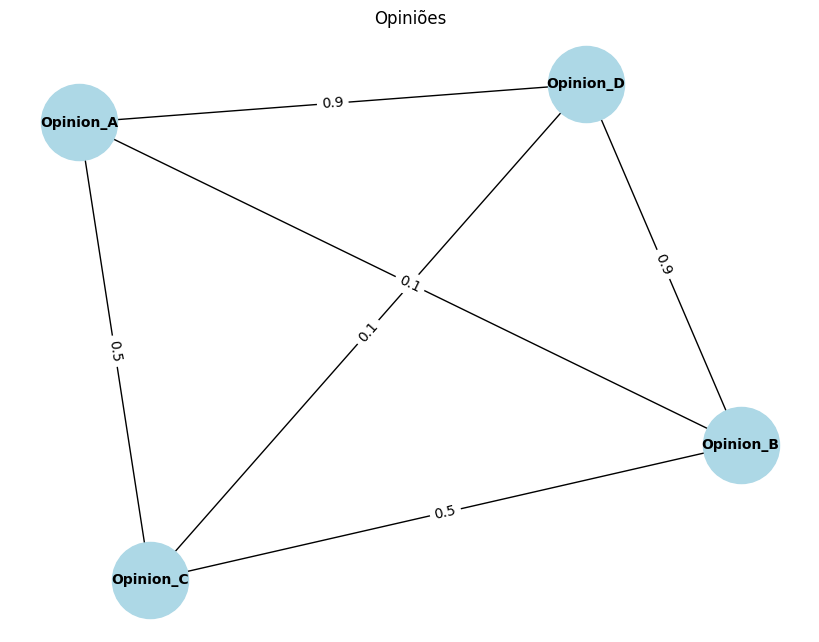

In [395]:
import random

import matplotlib.pyplot as plt

opinions = ['Opinion_A', 'Opinion_B', 'Opinion_C', 'Opinion_D']

weights = {
    ('Opinion_A', 'Opinion_B'): 0.1,  # low difficulty
    ('Opinion_B', 'Opinion_C'): 0.5,  # moderate difficulty
    ('Opinion_A', 'Opinion_D'): 0.9,  # high difficulty
    ('Opinion_D', 'Opinion_C'): 0.1,  # low difficulty
    ('Opinion_A', 'Opinion_C'): 0.5,  # moderate difficulty
    ('Opinion_B', 'Opinion_D'): 0.9   # moderate difficulty
}


opinion_g = nx.Graph()
opinion_g.add_nodes_from(opinions)


for (op1, op2), weight in weights.items():
    opinion_g.add_edge(op1, op2, weight=weight)

pos = nx.spring_layout(opinion_g)
labels = nx.get_edge_attributes(opinion_g, 'weight')


plt.figure(figsize=(8, 6))
nx.draw(opinion_g, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(opinion_g, pos, edge_labels=labels)
plt.title("Opiniões")
plt.show()

In [396]:
parameters = {  
    'population': 50,
    'steps': 100,
    'influencer_per': 0.05,
    'opinion_g' : opinion_g
}

In [397]:
model = SocialModel(parameters)

In [398]:
results = model.run()

removed edges - [(AgentNode (0), AgentNode (32)), (AgentNode (0), AgentNode (2)), (AgentNode (2), AgentNode (0)), (AgentNode (3), AgentNode (2)), (AgentNode (4), AgentNode (47)), (AgentNode (4), AgentNode (49)), (AgentNode (8), AgentNode (10)), (AgentNode (10), AgentNode (31)), (AgentNode (10), AgentNode (39)), (AgentNode (14), AgentNode (32)), (AgentNode (14), AgentNode (49)), (AgentNode (16), AgentNode (2)), (AgentNode (19), AgentNode (35)), (AgentNode (21), AgentNode (9)), (AgentNode (21), AgentNode (47)), (AgentNode (21), AgentNode (39)), (AgentNode (28), AgentNode (34)), (AgentNode (31), AgentNode (10)), (AgentNode (32), AgentNode (7)), (AgentNode (32), AgentNode (21)), (AgentNode (33), AgentNode (44)), (AgentNode (38), AgentNode (32)), (AgentNode (39), AgentNode (21)), (AgentNode (43), AgentNode (16)), (AgentNode (43), AgentNode (26)), (AgentNode (45), AgentNode (44)), (AgentNode (46), AgentNode (2)), (AgentNode (47), AgentNode (21))]
add edges - [(AgentNode (49), AgentNode (42))

In [399]:
import re

import matplotlib.pyplot as plt


def animation_plot(m, ax):

    ax.set_title("Animacao")
    
    # Plot network on second axis
    color_dict = {'Opinion_A':'b', 'Opinion_B':'r', 'Opinion_C':'g','Opinion_D':'y'}
    colors = [color_dict[c] for c in m.agents.opinion]

    labels = {}
    for agent, _ in m.network.graph.nodes(data=True):
        labels[agent] = re.search('\d+',str(agent)).group(0)

    sizes = [s * 10 for s in m.agents.vizinhos]
    nx.draw_kamada_kawai(m.network.graph, node_color=colors, node_size=sizes, ax=ax,with_labels = True, labels = labels,font_color="purple", horizontalalignment= "right")
    # nx.draw_circular(m.network.graph, node_color=colors, node_size=sizes, ax=ax)

fig, axs = plt.subplots(1, 1, figsize=(10, 10)) 
animation = ap.animate(SocialModel(parameters), fig, axs, animation_plot)

In [400]:
import IPython

IPython.display.HTML(animation.to_jshtml()) 

removed edges - [(AgentNode (0), AgentNode (4)), (AgentNode (0), AgentNode (34)), (AgentNode (0), AgentNode (16)), (AgentNode (3), AgentNode (6)), (AgentNode (6), AgentNode (14)), (AgentNode (6), AgentNode (31)), (AgentNode (11), AgentNode (32)), (AgentNode (15), AgentNode (4)), (AgentNode (16), AgentNode (45)), (AgentNode (16), AgentNode (21)), (AgentNode (19), AgentNode (35)), (AgentNode (21), AgentNode (16)), (AgentNode (21), AgentNode (32)), (AgentNode (23), AgentNode (3)), (AgentNode (24), AgentNode (39)), (AgentNode (25), AgentNode (35)), (AgentNode (26), AgentNode (30)), (AgentNode (28), AgentNode (48)), (AgentNode (30), AgentNode (26)), (AgentNode (32), AgentNode (11)), (AgentNode (32), AgentNode (21)), (AgentNode (32), AgentNode (28)), (AgentNode (39), AgentNode (24)), (AgentNode (43), AgentNode (6)), (AgentNode (47), AgentNode (42)), (AgentNode (49), AgentNode (31))]
add edges - [(AgentNode (49), AgentNode (34)), (AgentNode (49), AgentNode (34)), (AgentNode (49), AgentNode (3

In [24]:

random.uniform(0.7, 1)

0.9204371420760504

In [25]:
from scipy.stats import powerlaw

alpha = 2  
size = 100

random_numbers = powerlaw.rvs(alpha, size=size)
int_numbers = np.floor(random_numbers * 10).astype(int)


print(list(int_numbers))


[5, 8, 6, 7, 1, 9, 3, 4, 4, 9, 2, 8, 0, 8, 4, 9, 6, 8, 8, 9, 4, 6, 7, 8, 8, 7, 8, 8, 8, 2, 3, 8, 9, 6, 4, 7, 5, 5, 7, 8, 8, 3, 9, 2, 6, 6, 7, 5, 5, 7, 6, 8, 8, 4, 9, 1, 5, 8, 2, 9, 4, 8, 6, 9, 7, 7, 5, 5, 6, 8, 2, 5, 6, 4, 4, 8, 6, 9, 2, 1, 8, 2, 4, 6, 3, 7, 7, 5, 4, 9, 6, 3, 7, 4, 6, 9, 7, 9, 2, 8]


In [26]:
# random_numbers

In [27]:
a = powerlaw.rvs(0.5, size=1000) 

<Axes: ylabel='Count'>

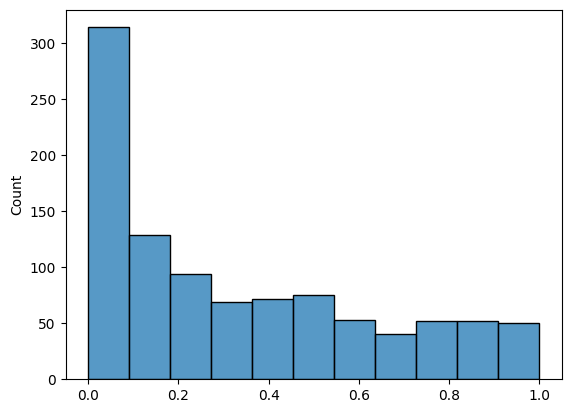

In [28]:
import seaborn as sns

sns.histplot(a)

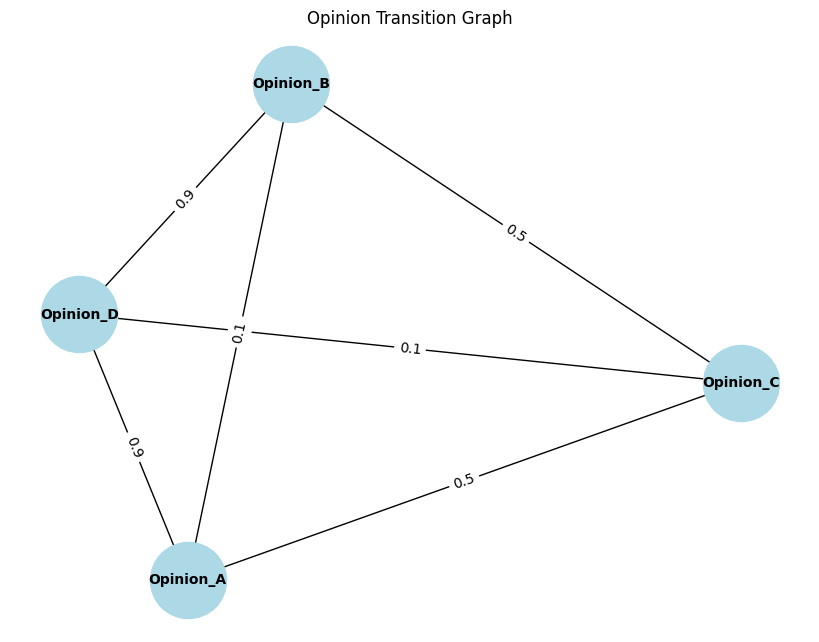

In [32]:
import random

import matplotlib.pyplot as plt

# Step 1: Define opinions and weights

opinions = ['Opinion_A', 'Opinion_B', 'Opinion_C', 'Opinion_D']

weights = {
    ('Opinion_A', 'Opinion_B'): 0.1,  # low difficulty
    ('Opinion_B', 'Opinion_C'): 0.5,  # moderate difficulty
    ('Opinion_A', 'Opinion_D'): 0.9,  # high difficulty
    ('Opinion_D', 'Opinion_C'): 0.1,  # low difficulty
    ('Opinion_A', 'Opinion_C'): 0.5,  # moderate difficulty
    ('Opinion_B', 'Opinion_D'): 0.9   # moderate difficulty
}


opinion_g = nx.Graph()
opinion_g.add_nodes_from(opinions)

for (op1, op2), weight in weights.items():
    opinion_g.add_edge(op1, op2, weight=weight)


pos = nx.spring_layout(opinion_g)
labels = nx.get_edge_attributes(opinion_g, 'weight')

plt.figure(figsize=(8, 6))
nx.draw(opinion_g, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(opinion_g, pos, edge_labels=labels)
plt.title("Opinion Transition Graph")
plt.show()

In [34]:
def shortest_path_difficulty(graph, source, target):
    try:
        path = nx.dijkstra_path(graph, source, target)
        difficulty = nx.dijkstra_path_length(graph, source, target)
        return path, difficulty
    except nx.NetworkXNoPath:
        return None, float('inf')

# Example usage
source_opinion = 'Opinion_A'
target_opinion = 'Opinion_C'
path, difficulty = shortest_path_difficulty(opinion_g, source_opinion, target_opinion)

print(f"Shortest path from {source_opinion} to {target_opinion}: {path}")
print(f"Total transition difficulty: {difficulty}")

Shortest path from Opinion_A to Opinion_C: ['Opinion_A', 'Opinion_C']
Total transition difficulty: 0.5


In [36]:
list(opinion_g.nodes)

['Opinion_A', 'Opinion_B', 'Opinion_C', 'Opinion_D']